In [96]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
rc('animation', html='jshtml')
from scipy.optimize import curve_fit
from scipy.special import erf

pd.set_option('display.max_columns', None)
from IPython.display import set_matplotlib_formats

#set_matplotlib_formats("png")
plt.rc("xtick", labelsize=16, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=16, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes",grid=True,linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid",ls=":",lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=16) #Font og fontstørrelse
plt.rc("figure",figsize=(5,3),dpi=250) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major",width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major",width=1.3) #Sætter tykkelsen på xticks

# Set before plotting
# plt.tick_params(direction="in", top=True, right=True, labelsize=15)


In [337]:
import os

# Specify the path to the directory
directory_path = 'data/'

# List to hold the filenames
filenames_135 = []

# Iterate over the files in the directory
for filename in os.listdir(directory_path):
    # Check if it's a file (not a directory)
    if os.path.isfile(os.path.join(directory_path, filename)):
        filenames.append(filename)



In [87]:
import pandas as pd

def create_df_one_file(filename: str, only_df: bool = False, ) -> (pd.DataFrame, dict):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    header_info = {}
    df = pd.DataFrame()
    event = 0
    
    for line in lines:
        line_strip = line.strip()
        if not line_strip:
            continue
        elif line_strip.startswith("%"):
            continue
            
        line_split = line_strip.split("\t")  
        
        if line_split[0] == "Event":
            event = int(line_split[1])
        elif event == 0:
            header_info[line_split[0]] = line_split[1]
        else:
            df.loc[event, line_split[0]] = line_split[1]
    
    if only_df:
        return df
    
    return df, header_info


def create_full_df(filenames: list) -> (pd.DataFrame, dict):
    
    df_tot, header = create_df_one_file(filenames[0])
    
    for filename in filenames[1:]:
        df = create_df_one_file(filename, True)
        df_tot = pd.concat([df_tot, df])
        
    return df_tot, header


In [86]:
lists[1:]

[1]

In [166]:
df_tot, header_tot = create_full_df(["data/Run-100-001.dat", "data/Run-100-002.dat"])

In [105]:
header_tot

{'version': '1 3',
 'TDC.res': '0.02441',
 'TDC.alt': '0',
 'TDC.join': '1',
 'ADC.req_hits': '1'}

Hvis der ikke er skrevet en enhed er enheden i bits 

Time: The time of measurement
Ion_Flag: Signal fra ionerne (ADC analog digital converter) indication af antal ioner ved målling ?
Laser_Phd: ?
Switch_Flag: ?
Laser_Flag: ?
Powermeter: Aflæsing af powermeter ved/fra laser 
HEX_B: Event hits på dele af neutral detectoren (ligger lang anion beamet)
HEX_x1: gns. x position af neutral (behøves ikke at være samme længde som HEX_B) de er individuelle detectorer
HEX_y1: gns. y position af neutral (behøves ikke at være samme længde som HEX_B)
HEZ_z1: gns. z position af neutral (behøves ikke at være samme længde som HEX_B)
(forskel ikke sikker mellem 1 og 2)
HEX_x2: gns. x position af neutral (behøves ikke at være samme længde som HEX_B)
HEX_y2: gns. y position af neutral (behøves ikke at være samme længde som HEX_B)
HEX_z2: gns. z position af neutral (behøves ikke at være samme længde som HEX_B)
( -1 må betyde et eller andet ? )
laser: konvertering af 1 eller 0, burder være ish konstant tal som viser at laseren er tændt
ESP_F: Alle electron events
HCH_B: Hører til paul trappen 
Trigger: liste som er ish konstant som fortæller hvor mange gange man kan måle
COIL_UP: Magnetfelt af coil op i A
COIL_DW: Magnetfelt af coil op i A
VG08: Trykket i en af ventilerne ved RF i mBar
RC02: Trykket i en af ventilerne ved Trappen i mBar
T_source_C: Temperaturen I Celcius 
ESP_U_drift: Electrode aflæser af drift i V øverst
ESP_U_F3: Electrode aflæser af drift inde i trappen Up i V
ESP_U_ext: Extrationen elctrode aflæser i V
ESP_D_F3: electrode aflæser af drift inde i trappen down i V
ESP_D_M1: electrode aflæser af drift nedfra og op i V
ESP_D_M2: electrode aflæser af drift nedfra og op i V
COIL_ALL_set_A: Parameter som sætter all andre coils i V
ESP_U_F2_A: electrode aflæser af drift Uppe
TCP_scan_step: Skridt tæller for mållinger 
TCP_scan_cycle: antal cyklusser siden genstart 
TCP_scan_round: afhænger af scan cycle tallet
erros: fejl i tællinger ved ikke hvad hvert 0 fortæller
proc_time: antal tid den venter til næste skridt i enten ms eller micro s 

In [128]:
# df configurations
df['errors_sum'] = df['errors'].apply(lambda x: sum(map(int, x.split())))


In [144]:
# Constants 
No_triggers = 100
T_cycle = 200
synch = False  # in Matlab this is 0 or 1 ? So I will do True or False

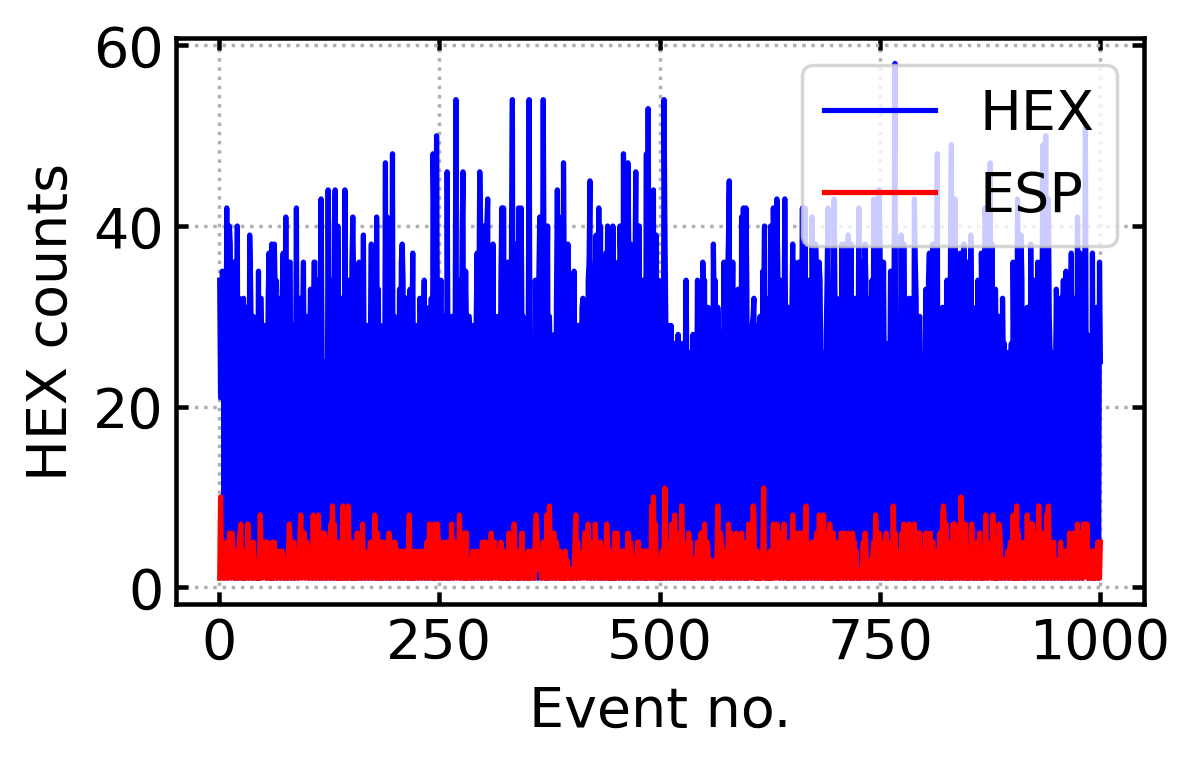

In [137]:
# Assuming your DataFrame is called 'df'
# 'Event' is the index (row numbers), so we don't need to define Event_counter

# Calculate the length of each event in the 'TDC1.Trigger' and other columns
L_trigger = df['TDC1.Trigger'].apply(lambda x: len(x.split()))
ESP_length = df['TDC1.ESP_F'].apply(lambda x: len(str(x).split()))  # Using str() to handle NaNs
HEX_length = df['TDC1.HEX_B'].apply(lambda x: len(str(x).split()))
HCH_length = df['TDC1.HCH_B'].apply(lambda x: len(str(x).split()))

# General cut condition, assuming 'errors' and 'proc_time' are in the dataframe as numeric
cut_all = (df['errors_sum'].astype(int) < 1) & (L_trigger == No_triggers)& (df['proc_time'].astype(float) < T_cycle)

# Specific cuts based on 'ADC.Laser_Flag' and 'ADC.Ion_Flag'
cut_laser_on_ion_on = cut_all & (df['ADC.Laser_Flag'].astype(int) > 500) & (df['ADC.Ion_Flag'].astype(int) > 500)
cut_laser_off_ion_on = cut_all & (df['ADC.Laser_Flag'].astype(int) <= 500) & (df['ADC.Ion_Flag'].astype(int) > 500)
cut_laser_on_ion_off = cut_all & (df['ADC.Laser_Flag'].astype(int) > 500) & (df['ADC.Ion_Flag'].astype(int) <= 500)
cut_laser_off_ion_off = cut_all & (df['ADC.Laser_Flag'].astype(int) <= 500)& (df['ADC.Ion_Flag'].astype(int) <= 500)

# Plotting the results
plt.figure(1000)
plt.clf()
plt.plot(df.index, HEX_length, '-b', label='HEX')  # Plot HEX_length vs Event number
plt.plot(df.index, ESP_length, '-r', label='ESP')  # Plot ESP_length vs Event number
plt.xlabel('Event no.')
plt.ylabel('HEX counts')
plt.legend()
plt.box(True)
plt.show()


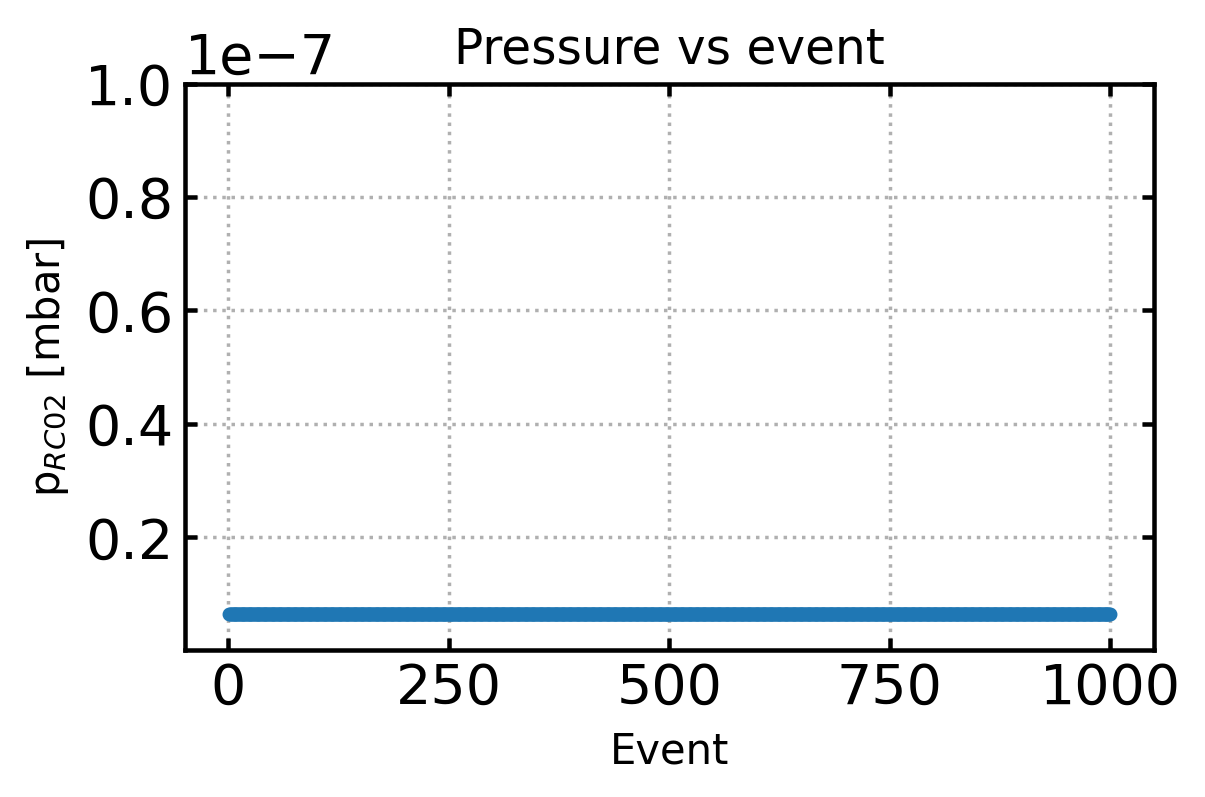

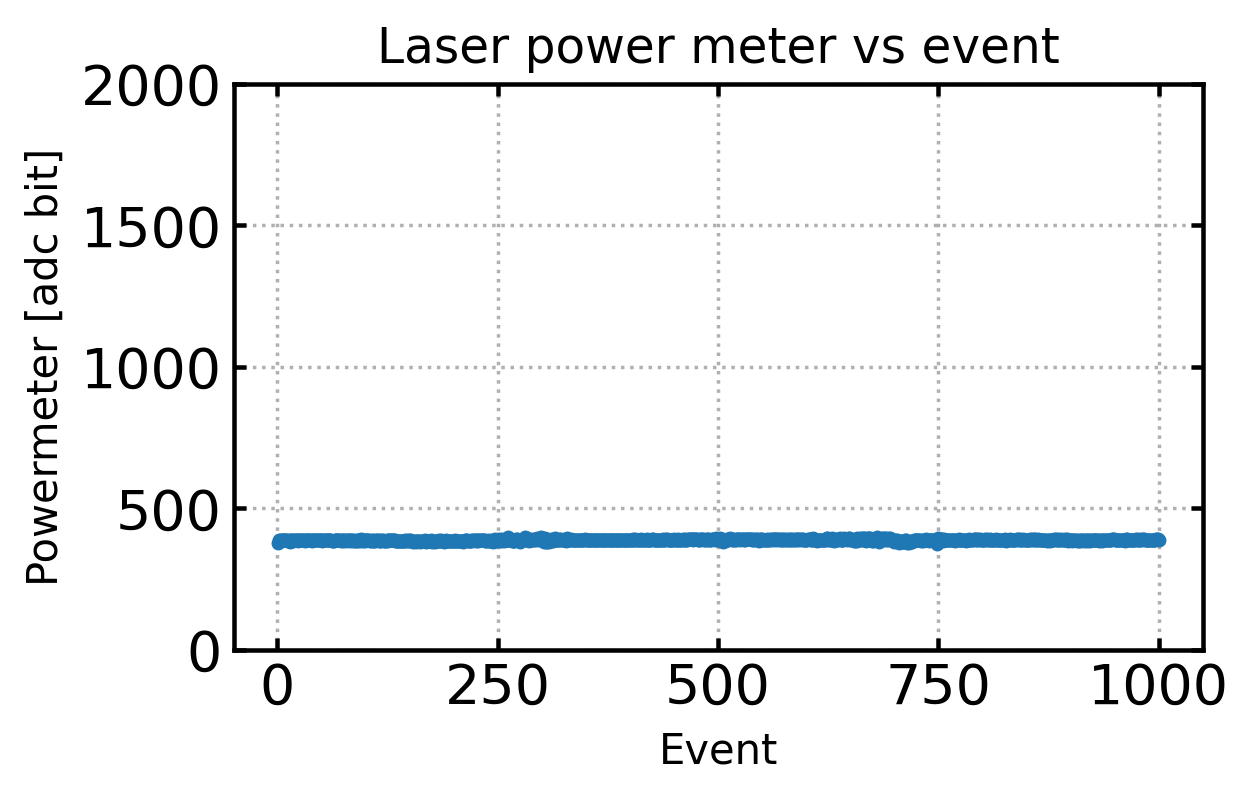

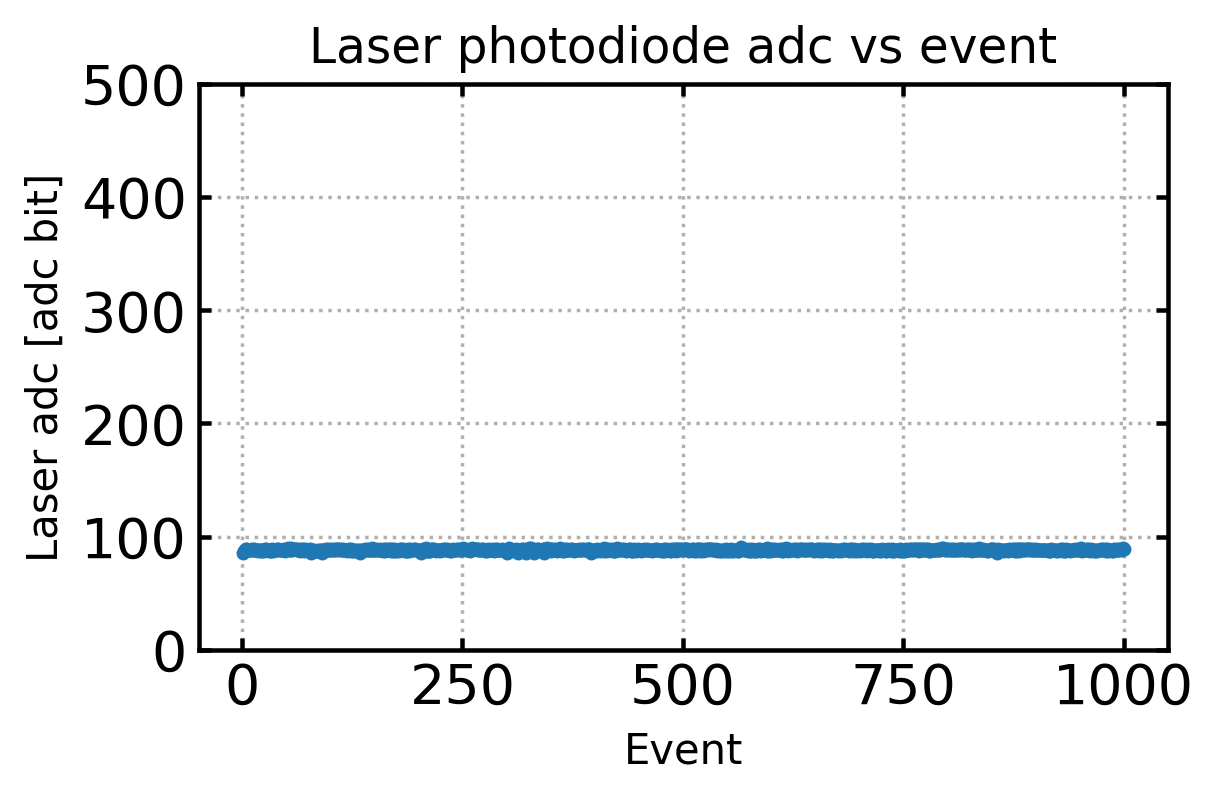

In [145]:
# Range of events, assuming df.index represents event numbers
range_vals = df.index

# Plot 1: Pressure vs Event (RC02 Pressure)
plt.figure(100)
plt.clf()
plt.title('Pressure vs event', fontsize=14)
plt.xlabel('Event', fontsize=12)
plt.ylabel(r'p$_{RC02}$ [mbar]', fontsize=12)
plt.yscale('linear')
plt.xscale('linear')
plt.ylim([1e-10, 1e-7])
plt.plot(range_vals, df['RC02'].astype(float) * 1e-7, '.')
plt.grid(True, which='both')
plt.box(True)
plt.show()

# Plot 2: Laser Power Meter vs Event
plt.figure(101)
plt.clf()
plt.title('Laser power meter vs event', fontsize=14)
plt.xlabel('Event', fontsize=12)
plt.ylabel('Powermeter [adc bit]', fontsize=12)
plt.ylim([0, 2000])
plt.plot(range_vals, df['ADC.Powermeter'].astype(float), '.')
plt.grid(True)
plt.box(True)
plt.show()

# Plot 3: Laser Photodiode ADC vs Event
plt.figure(103)
plt.clf()
plt.title('Laser photodiode adc vs event', fontsize=14)
plt.xlabel('Event', fontsize=12)
plt.ylabel('Laser adc [adc bit]', fontsize=12)
plt.ylim([0, 500])
plt.plot(range_vals, df['ADC.Laser_Phd'].astype(float), '.')
plt.grid(True)
plt.box(True)
plt.show()

# Synchronization Section
if synch:
    Event_no = df.index
    HEX_length = df['TDC1.HEX_B'].apply(lambda x: len(str(x).split())).values
    E_ph_HEX = df['WavE_AMO_eV_'].astype(float).values
    Shutter = df['shutter_status'].astype(float).values

    # Plot 4: Counts on HEX vs Event
    plt.figure(124)
    plt.clf()
    plt.title('Counts on HEX vs event', fontsize=14)
    plt.plot(Event_no, HEX_length, label='HEX counts')
    plt.plot(Event_no, E_ph_HEX * 10, '-k', label='Photon energy * 10')
    plt.plot(Event_no, Shutter * 100, '--g', label='Shutter status * 100')
    plt.xlabel('Event', fontsize=12)
    plt.ylabel('Hex B counts', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.box(True)
    # plt.savefig('counts_vs_event.png')
    plt.show()

    # Plot 5: Counts on ESP vs Event
    ESP_length = df['TDC1.ESP_F'].apply(lambda x: len(str(x).split())).values
    plt.figure(125)
    plt.clf()
    plt.title('Counts on ESP vs event', fontsize=14)
    plt.plot(Event_no, ESP_length, label='ESP counts')
    plt.plot(Event_no, E_ph_HEX * 10, '-k', label='Photon energy * 10')
    plt.plot(Event_no, Shutter * 100, '--g', label='Shutter status * 100')
    plt.xlabel('Event', fontsize=12)
    plt.ylabel('ESP counts', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.box(True)
    # plt.savefig('counts_vs_event_ESP.png')
    plt.show()


In [249]:
# Test funcs 

def tof_without_ringing_test(tof_data, ring_correction):
    """
    A temporary function to remove ringing effects from TOF data.
    Shifts the TOF data by a ring_correction value (in this case, simply subtracting the correction).
    
    Parameters:
    tof_data: list or array of TOF data (can be a single value)
    ring_correction: the amount to adjust the TOF data by (in nanoseconds)
    
    Returns:
    Corrected TOF data.
    """
    if isinstance(tof_data, (list, np.ndarray)):
        return np.array(tof_data) - ring_correction
    else:
        return tof_data - ring_correction
    
def tof_without_ringing(tof_with_ringing, dt):
    """
    Removes ringing from a TOF signal based on a threshold dt.
    
    Parameters:
        tof_with_ringing (list or pd.Series): Input TOF values with ringing.
        dt (float): The threshold to determine ringing.
    
    Returns:
        list: TOF values without ringing or [-1] if all values are removed.
    """
    # Initialize the output TOF array without ringing
    tof_without_ringing = list(tof_with_ringing)

    # Check if the input TOF has more than one value
    if len(tof_with_ringing) > 1:
        kk_test = 1  # Initialize the loop control variable
        
        # Loop until no more ringing values are detected
        while kk_test > 0:
            # Shift TOF array down by one element
            tof_without_ringing_1 = [0] + tof_without_ringing[:-1]  # Shifted TOF array
            
            # Calculate the difference between current and shifted TOF
            a = [current - previous for current, previous in zip(tof_without_ringing, tof_without_ringing_1)]
            
            # Find indices where the difference is less than dt
            idx_a = [i for i, value in enumerate(a) if value < dt]
            
            # Remove these indices from the TOF without ringing
            for index in sorted(idx_a, reverse=True):  # Remove from the end to avoid index shifting
                del tof_without_ringing[index]

            # Update the control variable
            kk_test = len(idx_a)

    # If there are values left after filtering
    if len(tof_without_ringing) > 0:
        U = tof_without_ringing  # Return the filtered TOF values
    else:
        U = [-1]  # If no values remain, return [-1]

    return U



def hex_position_for_event_test(HEX_B, HEX_x1, HEX_x2, HEX_y1, HEX_y2, 
                           HEX_z1, HEX_z2, dt_HEX_time_sum, dt_HEX_accept, deltaT):
    """
    A temporary function to calculate HEX position for an event.
    Ensures input arrays have the same shape using numpy's broadcast or padding.
    
    Parameters:
    HEX_B, HEX_x1, HEX_x2, HEX_y1, HEX_y2, HEX_z1, HEX_z2: TOF data for various hex detectors.
    dt_HEX_time_sum: Time sum restriction.
    dt_HEX_accept: Time acceptance range.
    deltaT: Time resolution (assumed in ns).
    
    Returns:
    A numpy array simulating the HEX position data.
    """
    
    # Find the maximum length of the input arrays
    max_length = max(len(HEX_x1), len(HEX_x2), len(HEX_y1), len(HEX_y2), len(HEX_z1), len(HEX_z2))
    
    # Function to pad or truncate arrays to the same length
    def pad_to_length(arr, length):
        arr = np.array(arr)
        if len(arr) < length:
            # Pad the array with zeros if it's shorter
            return np.pad(arr, (0, length - len(arr)), 'constant')
        else:
            # Truncate the array if it's longer
            return arr[:length]

    # Pad or truncate all arrays to the same length
    HEX_x1 = pad_to_length(HEX_x1, max_length)
    HEX_x2 = pad_to_length(HEX_x2, max_length)
    HEX_y1 = pad_to_length(HEX_y1, max_length)
    HEX_y2 = pad_to_length(HEX_y2, max_length)
    HEX_z1 = pad_to_length(HEX_z1, max_length)
    HEX_z2 = pad_to_length(HEX_z2, max_length)
    HEX_B = pad_to_length(HEX_B, max_length)

    # Simulate the U_hex array
    U_hex = np.array([
        HEX_B,  # Simulate B data
        HEX_y1,  # Simulate y1 data
        HEX_y2,  # Simulate y2 data
        HEX_z1,  # Simulate z1 data
        HEX_z2,  # Simulate z2 data
        HEX_x1 + HEX_x2,  # Simulate X_HEX_mm (sum of x1 and x2)
        HEX_y1 + HEX_y2   # Simulate Y_HEX_mm (sum of y1 and y2)
    ])
    
    return U_hex


def hex_position_for_event(B, x1, x2, y1, y2, z1, z2, dt_HEX_time_sum, dt_HEX_accept, deltaT):
    """
    Calculates the hexagonal position for events based on the input parameters.
    
    Parameters:
        B (list or pd.Series): Input B values.
        x1, x2, y1, y2, z1, z2 (list or pd.Series): Position data for the event.
        dt_HEX_time_sum (float): Parameter for time sum calculation.
        dt_HEX_accept (float): Acceptance time window.
        deltaT (float): Time calibration factor.
        
    Returns:
        list: Calculated positions and assignments.
    """
    
    # Scale the input values by deltaT
    HEX_B = [b * deltaT for b in B]
    HEX_x1 = [x * deltaT for x in x1]
    HEX_x2 = [x * deltaT for x in x2]
    HEX_y1 = [y * deltaT for y in y1]
    HEX_y2 = [y * deltaT for y in y2]
    HEX_z1 = [z * deltaT for z in z1]
    HEX_z2 = [z * deltaT for z in z2]

    # Initialize assignment lists with default values
    By_HEX_asign = [-1]
    y1_HEX_asign = [-1]
    y2_HEX_asign = [-1]
    Bz_HEX_asign = [-1]
    z1_HEX_asign = [-1]
    z2_HEX_asign = [-1]
    
    # Check if the first element of HEX_B is greater than zero
    if HEX_B[0] > 0:
        # Loop over B's in the event
        for j in range(len(HEX_B)):
            # Find indices of possible matches within the acceptance window
            idx_y1 = [i for i in range(len(HEX_y1)) if abs(HEX_B[j] - HEX_y1[i]) < dt_HEX_accept]
            idx_y2 = [i for i in range(len(HEX_y2)) if abs(HEX_B[j] - HEX_y2[i]) < dt_HEX_accept]
            idx_z1 = [i for i in range(len(HEX_z1)) if abs(HEX_B[j] - HEX_z1[i]) < dt_HEX_accept]
            idx_z2 = [i for i in range(len(HEX_z2)) if abs(HEX_B[j] - HEX_z2[i]) < dt_HEX_accept]

            # Possible positions based on the found indices
            y1_poss = [HEX_y1[i] for i in idx_y1]
            y2_poss = [HEX_y2[i] for i in idx_y2]
            z1_poss = [HEX_z1[i] for i in idx_z1]
            z2_poss = [HEX_z2[i] for i in idx_z2]

            # Loop over possible combinations of y1, y2, z1, z2
            for ky1 in range(len(y1_poss)):
                for ky2 in range(len(y2_poss)):
                    for kz1 in range(len(z1_poss)):
                        for kz2 in range(len(z2_poss)):
                            B_here = HEX_B[j]
                            y1_here = y1_poss[ky1]
                            y2_here = y2_poss[ky2]
                            z1_here = z1_poss[kz1]
                            z2_here = z2_poss[kz2]
                            
                            # Time sum calculations for y
                            T_sumy_here = y1_here + y2_here - 2 * B_here
                            Dy_here = y1_here - y2_here
                            # print(Dy_here)
                            T_sumy_limit_up = T_sum_HEX_y_upper(Dy_here)  
                            # Assuming this is a predefined function
                            T_sumy_limit_dw = T_sum_HEX_y_lower(Dy_here)  
                            # Assuming this is a predefined function
                            select_y = (T_sumy_here > T_sumy_limit_dw) and (T_sumy_here < T_sumy_limit_up)
                            
                            # Time sum calculations for z
                            T_sumz_here = z1_here + z2_here - 2 * B_here
                            Dz_here = z1_here - z2_here
                            T_sumz_limit_up = T_sum_HEX_z_upper(Dz_here)  
                            # Assuming this is a predefined function
                            T_sumz_limit_dw = T_sum_HEX_z_lower(Dz_here)  
                            # Assuming this is a predefined function
                            select_z = (T_sumz_here > T_sumz_limit_dw) and (T_sumz_here < T_sumz_limit_up)

                            # If both conditions for y and z are satisfied, assign values
                            if select_y and select_z:
                                By_HEX_asign.append(B_here)
                                y1_HEX_asign.append(y1_here)
                                y2_HEX_asign.append(y2_here)
                                Bz_HEX_asign.append(B_here)
                                z1_HEX_asign.append(z1_here)
                                z2_HEX_asign.append(z2_here)

                                # Remove matched indices from the original lists
                                for idx in [idx_y1, idx_y2, idx_z1, idx_z2]:
                                    for i in sorted(idx, reverse=True):
                                        del HEX_y1[i]
                                        del HEX_y2[i]
                                        del HEX_z1[i]
                                        del HEX_z2[i]

    # Calibration parameters
    alpha_HEX_y = -0.323  # mm/ns
    beta_HEX_y = 0        # mm

    alpha_HEX_z = -0.327  # mm/ns
    beta_HEX_z = -0.825 * alpha_HEX_z  # mm

    # Convert time to mm in the hexagonal frame
    y_hex_mm = [alpha_HEX_y * (y1 - y2) + beta_HEX_y for y1, y2 in zip(y1_HEX_asign, y2_HEX_asign)]
    z_hex_mm = [alpha_HEX_z * (z1 - z2) + beta_HEX_z for z1, z2 in zip(z1_HEX_asign, z2_HEX_asign)]

    # Transform from 60 degree frame to lab frame
    theta = 60 * 3.14159 / 180  # Convert degrees to radians
    X_HEX_mm = [(-1 / sin(theta)) * (y * 1 + cos(theta) * z) for y, z in zip(y_hex_mm, z_hex_mm)]
    Y_HEX_mm = [(-1 / sin(theta)) * (y * 0 - sin(theta) * z) for y, z in zip(y_hex_mm, z_hex_mm)]

    # Rotation of detector frame to lab frame
    phi_rot = 57 * 3.14159 / 180  # Convert degrees to radians
    X_HEX_lab_mm = [cos(phi_rot) * x + sin(phi_rot) * y for x, y in zip(X_HEX_mm, Y_HEX_mm)]
    Y_HEX_lab_mm = [-sin(phi_rot) * x + cos(phi_rot) * y for x, y in zip(X_HEX_mm, Y_HEX_mm)]

    # Prepare the output
    U = [By_HEX_asign, y1_HEX_asign, y2_HEX_asign, z1_HEX_asign, z2_HEX_asign, X_HEX_lab_mm, Y_HEX_lab_mm]
    
    return U




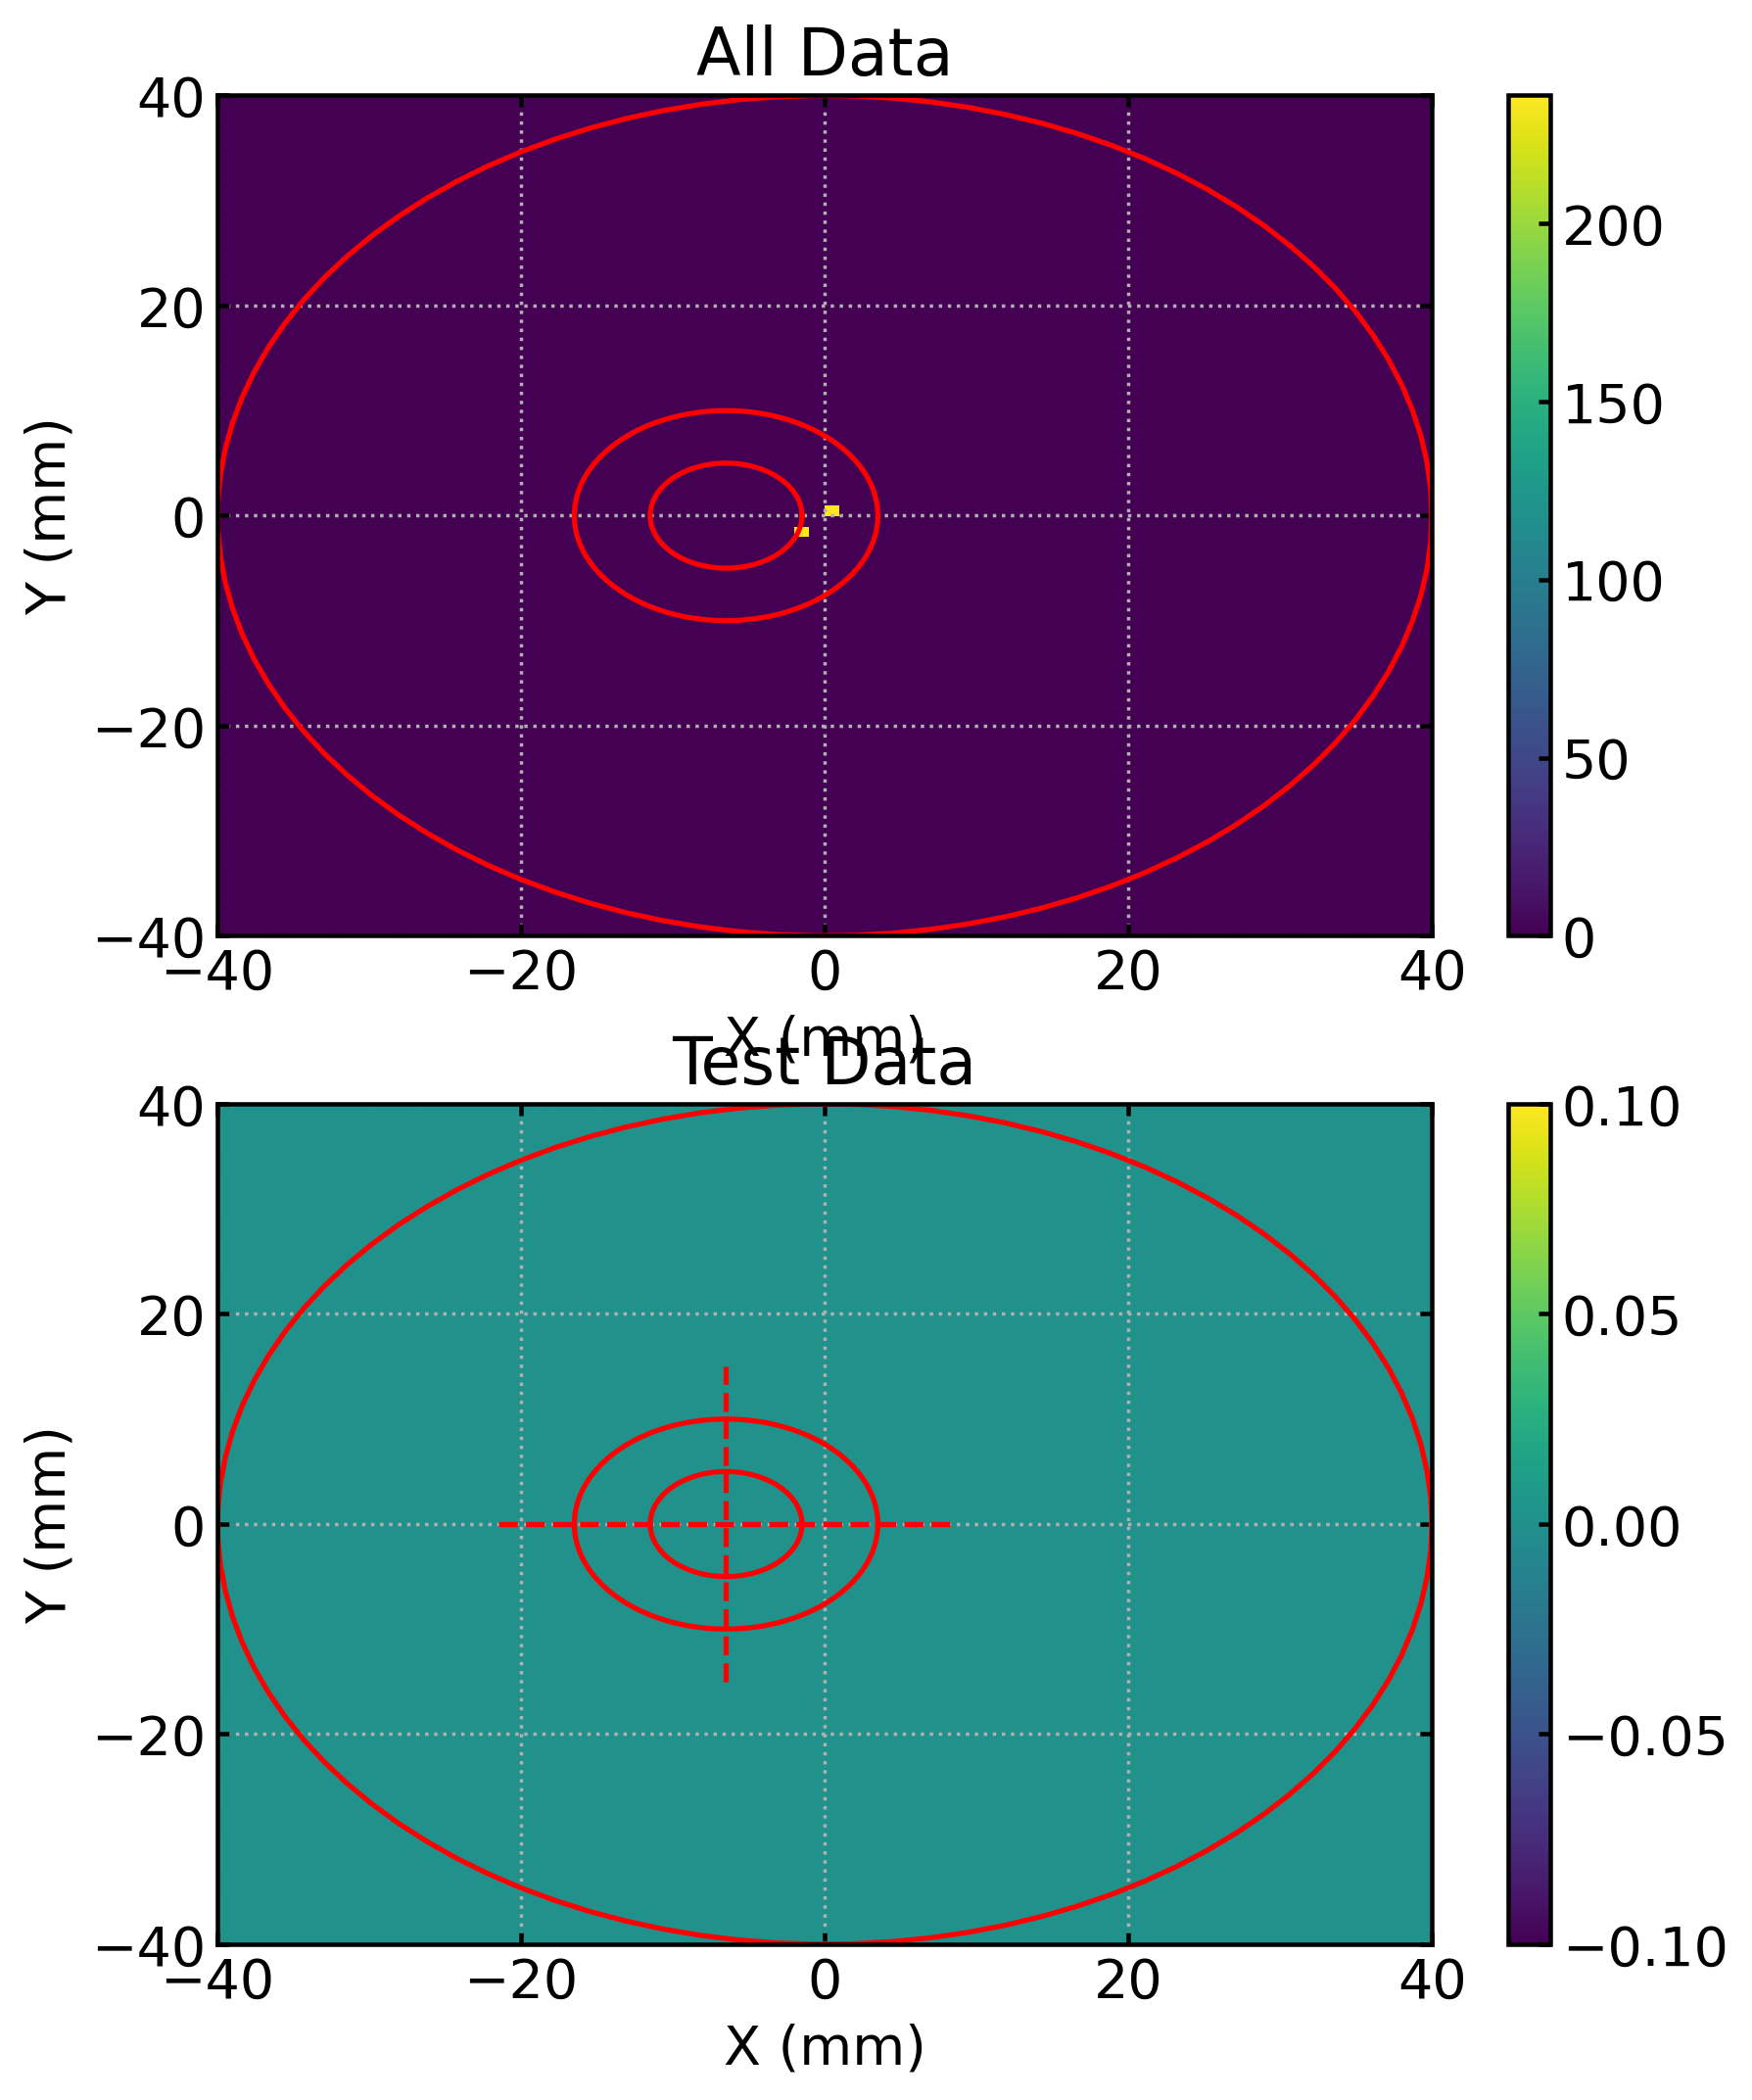

In [286]:
df = df_tot.copy()

# Assuming df is your DataFrame
deltaT = 0.02441  # dwell time in ns - conversion is nor

tof_bin = np.arange(0.8, 10.1, 0.00001)  # ms

# LASER TOF all data
tof_all_LAS = df['TDC1.laser'].astype(float) * deltaT / 1e6  # Laser all TOF data

# Correct HEX data for ringing
dt_ring_HEX = 100  # ns
df['TDC1_HEX_C'] = df['TDC1.HEX_B'].apply(
    lambda x: tof_without_ringing([float(i) for i in x.split()], int(dt_ring_HEX / deltaT)))
df['TDC1_HEX_x1C'] = df['TDC1.HEX_x1'].apply(
    lambda x: tof_without_ringing([float(i) for i in x.split()], int(dt_ring_HEX / deltaT)))
df['TDC1_HEX_y1C'] = df['TDC1.HEX_y1'].apply(
    lambda x: tof_without_ringing([float(i) for i in x.split()], int(dt_ring_HEX / deltaT)))
df['TDC1_HEX_z1C'] = df['TDC1.HEX_z1'].apply(
    lambda x: tof_without_ringing([float(i) for i in x.split()], int(dt_ring_HEX / deltaT)))
df['TDC1_HEX_x2C'] = df['TDC1.HEX_x2'].apply(
    lambda x: tof_without_ringing([float(i) for i in x.split()], int(dt_ring_HEX / deltaT)))
df['TDC1_HEX_y2C'] = df['TDC1.HEX_y2'].apply(
    lambda x: tof_without_ringing([float(i) for i in x.split()], int(dt_ring_HEX / deltaT)))
df['TDC1_HEX_z2C'] = df['TDC1.HEX_z2'].apply(
    lambda x: tof_without_ringing([float(i) for i in x.split()], int(dt_ring_HEX / deltaT)))

dt_HEX_accept = 200  # For presorting
dt_HEX_time_sum = 4  # Time sum restriction

df['X_HEX_mm'] = None
df['Y_HEX_mm'] = None

for k in range(len(df.index)):
    HEX_B = df['TDC1_HEX_C'].iloc[k]
    HEX_x1 = df['TDC1_HEX_x1C'].iloc[k]
    HEX_x2 = df['TDC1_HEX_x2C'].iloc[k]
    HEX_y1 = df['TDC1_HEX_y1C'].iloc[k]
    HEX_y2 = df['TDC1_HEX_y2C'].iloc[k]
    HEX_z1 = df['TDC1_HEX_z1C'].iloc[k]
    HEX_z2 = df['TDC1_HEX_z2C'].iloc[k]

    # Assuming hex_position_for_event returns a similar structure to U_hex in MATLAB
    U_hex = hex_position_for_event_test(HEX_B, HEX_x1, HEX_x2, HEX_y1, HEX_y2,
                                   HEX_z1, HEX_z2, dt_HEX_time_sum, dt_HEX_accept, deltaT)
    k +=1
    df.at[k, 'TDC1.HEX_B'] = U_hex[0, :]
    df.at[k, 'TDC1.HEX_y1'] = U_hex[1, :]
    df.at[k, 'TDC1.HEX_y2'] = U_hex[2, :]
    df.at[k, 'TDC1.HEX_z1'] = U_hex[3, :]
    df.at[k, 'TDC1.HEX_z2'] = U_hex[4, :]
    df.at[k, 'X_HEX_mm'] = U_hex[5, :]  # mm
    df.at[k, 'Y_HEX_mm'] = U_hex[6, :]

# HEX reference to LASER
df['TDC1.laser'] = df['TDC1.laser'].astype(float)
df['HEX_ref_LAS_ns'] = df.apply(lambda row: row['TDC1.HEX_B'] - (row['TDC1.laser'] * deltaT), axis=1)

# TOF data for all events
df['TCP_scan_step'] = df['TCP_scan_step'].astype(float)
cut_step = df['TCP_scan_step'] < 15
T_all = np.concatenate(df.loc[cut_step, 'HEX_ref_LAS_ns'].values)
X_all = np.concatenate(df.loc[cut_step, 'X_HEX_mm'].values) + 0  # Add 0 or a specific offset
Y_all = np.concatenate(df.loc[cut_step, 'Y_HEX_mm'].values) 

# Time range selection
I_test = np.where((T_all * 1e-3 > 17.0) & (T_all * 1e-3 < 19.5))[0]

# Bins for histogram
X_bin = np.arange(-50, 51, 1)
Y_bin = np.arange(-50, 51, 1)

# 2D Histograms
hist_xy, _, _ = np.histogram2d(X_all, Y_all, bins=[X_bin, Y_bin])
hist_xy_test, _, _ = np.histogram2d(X_all[I_test], Y_all[I_test], bins=[X_bin, Y_bin])

# Plotting
t = np.linspace(0, 2 * np.pi, 100)
X_0 = -6.5
Y_0 = 0.0
X_sig = X_0 + 10 * np.cos(t)
X_sig1 = X_0 + 5 * np.cos(t)
Y_sig1 = Y_0 + 5 * np.sin(t)
Y_sig = 10 * np.sin(t)
X_det = 40 * np.cos(t)
Y_det = 40 * np.sin(t)

plt.figure(1, figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.pcolor(X_bin, Y_bin, hist_xy.T, shading='auto')
plt.plot(X_det, Y_det, '-r')
plt.plot(X_sig, Y_sig, 'r')
plt.plot(X_sig1, Y_sig1, 'r')
plt.xlim([-40, 40])
plt.ylim([-40, 40])
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('All Data')

plt.subplot(2, 1, 2)
plt.pcolor(X_bin, Y_bin, hist_xy_test.T, shading='auto')
plt.plot(X_det, Y_det, '-r')
plt.plot(X_sig, Y_sig, 'r')
plt.plot(X_sig1, Y_sig1, 'r')

list_1 = np.array([-15, 15])
list_2 = np.array([1, 1])

plt.plot(list_1 + X_0, list_2 * Y_0, '--r')
plt.plot(list_2 * X_0, list_1 + Y_0, '--r')
plt.xlim([-40, 40])
plt.ylim([-40, 40])
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Test Data')

plt.show()
df2 = df.copy()

<ipython-input-326-fa452811344c>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tof_HEX_ref_LAS = np.array(HEX_ref_LAS) * deltaT / 1e6  # HEX referenced to laser ringing
<ipython-input-326-fa452811344c>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tof_ESP_ref_LAS = np.array(ESP_ref_LAS) * deltaT / 1e6  # ESP referenced to laser


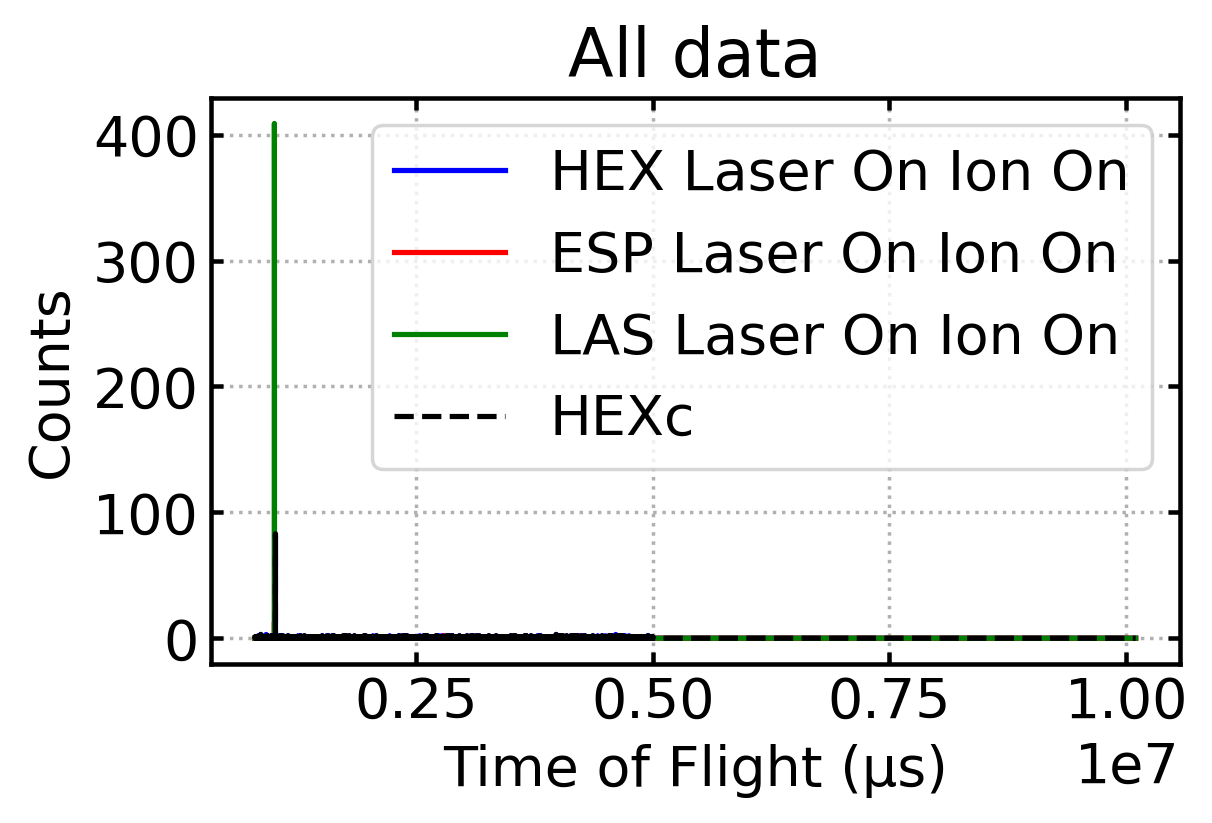

In [326]:
# Assuming df is a dictionary containing the necessary data in pandas DataFrames/Series
# Also assuming deltaT and other variables are already defined.
df = df2.copy()

# Old reference
HEX_ref_LAS = [df['TDC1_HEX_C'][k + 1] - df['TDC1.laser'][k + 1] for k in range(len(df['TDC1.laser']))]
tof_HEX_ref_LAS = np.array(HEX_ref_LAS) * deltaT / 1e6  # HEX referenced to laser ringing

# New reference for B_ref (commented out in MATLAB, left out here too)
# B_ref_LAS = [df['TDC1_HEX_C'][k].T - df['TDC1_laser'][k] for k in range(len(df['TDC1_laser']))]
# tof_B_ref_LAS = np.array(B_ref_LAS) * deltaT / 1e6  

# Correction of ESP data for ringing
dt_ring_HEX = 100  # ns

# df['TDC1_ESP_C'] = df['TDC1_ESP_F']  # Commented out in MATLAB
df['TDC1.ESP_F'] = df['TDC1.ESP_F'].apply(lambda x: [float(i) for i in x.split()])
df['TDC1_ESP_C'] = [tof_without_ringing(df['TDC1.ESP_F'][k + 1], int(dt_ring_HEX / deltaT)) for k in range(len(df['TDC1.laser']))]
df['TDC1_ESP_C'] = np.array(df['TDC1_ESP_C']).T

ESP_ref_LAS = [df['TDC1_ESP_C'][k + 1] - df['TDC1.laser'][k + 1].T for k in range(len(df['TDC1.laser']))]
tof_ESP_ref_LAS = np.array(ESP_ref_LAS) * deltaT / 1e6  # ESP referenced to laser

# TOF data
tof_all_HEX = df['TDC1_HEX_C'].apply(lambda x: [i * deltaT / 1e6 for i in x])  # ms % HEX all TOF data with ringing cut

# Data - Direct TOFs
tof_LAS_on_ion_on = np.array(df['TDC1.laser'][cut_laser_on_ion_on]) * deltaT / 1e6  # ms % LASER data
tof_LAS_on_ion_off = np.array(df['TDC1.laser'][cut_laser_on_ion_off]) * deltaT / 1e6

tof_HEX_laser_on_ion_on = np.array(df['TDC1.HEX_B'][cut_laser_on_ion_on]) * deltaT / 1e6  # ms % HEX data
tof_HEX_laser_on_ion_off = np.array(df['TDC1.HEX_B'][cut_laser_on_ion_off]) * deltaT / 1e6  # ms % HEX data

tof_ESP_laser_on_ion_on = df['TDC1.ESP_F'][cut_laser_on_ion_on].apply(lambda x: [i * deltaT / 1e6 for i in x])  # ms % ESP data
tof_ESP_laser_on_ion_off = df['TDC1.ESP_F'][cut_laser_on_ion_off].apply(lambda x: [i * deltaT / 1e6 for i in x])  # ms % ESP data

# Injection counts
injection_laser_on_ion_on = len(df[cut_laser_on_ion_on])
injection_laser_on_ion_off = len(df[cut_laser_on_ion_off])

# TOF histograms
sign_HEX_laser_on_ion_on = np.histogram(np.concatenate(tof_HEX_laser_on_ion_on), bins=tof_bin)[0]
sign_HEX_laser_on_ion_off = np.histogram(np.concatenate(tof_HEX_laser_on_ion_off), bins=tof_bin)[0]

sign_HEXc = np.histogram(np.concatenate(np.array(tof_all_HEX)), bins=tof_bin)[0]

sign_ESP_laser_on_ion_on = np.histogram(np.concatenate(np.array(tof_ESP_laser_on_ion_on)), bins=tof_bin)[0]
sign_ESP_laser_on_ion_off = np.histogram(np.concatenate(np.array(tof_ESP_laser_on_ion_off)), bins=tof_bin)[0]

sign_LAS_laser_on_ion_on = np.histogram(tof_LAS_on_ion_on, bins=tof_bin)[0]
sign_LAS_laser_on_ion_off = np.histogram(tof_LAS_on_ion_off, bins=tof_bin)[0]

# TOF histograms relative to laser
tof_bin_REF = np.arange(-10, 10.001, 0.001) * 1e-3
sign_HEX_LAS_laser_on_ion_on = np.histogram(np.concatenate(tof_HEX_ref_LAS), bins=tof_bin_REF)[0]
sign_ESP_LAS_laser_on_ion_on = np.histogram(np.concatenate(tof_ESP_ref_LAS), bins=tof_bin_REF)[0]

sign_HEX = np.histogram(np.concatenate(np.array(tof_all_HEX)), bins=tof_bin)[0]

# Plotting the data
import matplotlib.pyplot as plt

plt.figure(100)
plt.clf()
plt.title('All data')
plt.plot(tof_bin[:-1] * 1e6, sign_HEX_laser_on_ion_on, '-b', label='HEX Laser On Ion On')
plt.plot(tof_bin[:-1] * 1e6, sign_ESP_laser_on_ion_on, '-r', label='ESP Laser On Ion On')
plt.plot(tof_bin[:-1] * 1e6, sign_LAS_laser_on_ion_on, '-g', label='LAS Laser On Ion On')
plt.plot(tof_bin[:-1] * 1e6, sign_HEXc, '--k', label='HEXc')

plt.xlabel('Time of Flight (µs)')
plt.ylabel('Counts')
plt.legend()
plt.show()


In [331]:
max(sign_HEX_LAS_laser_on_ion_on), injection_laser_on_ion_on

(1, 982)

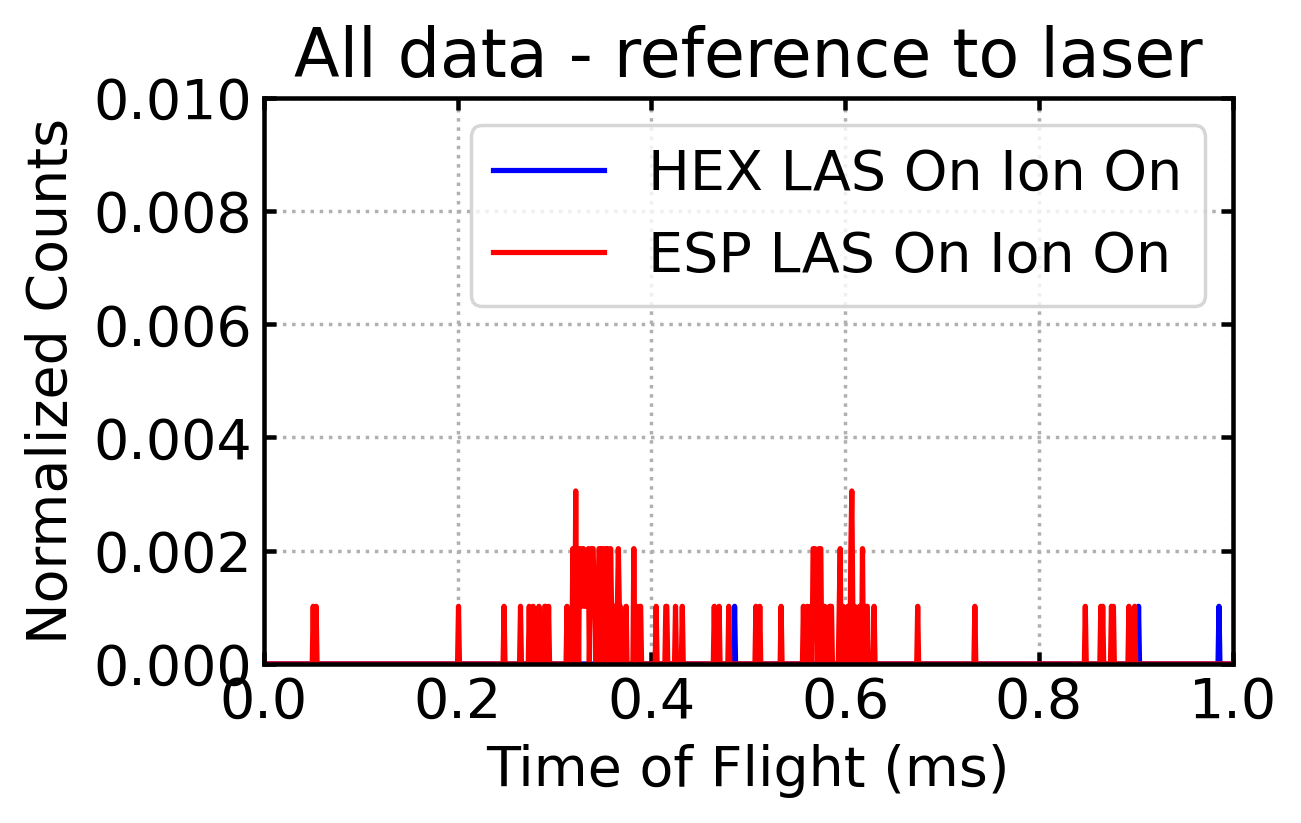

In [334]:
# Plotting the data relative to laser reference
plt.figure(200)
plt.clf()
plt.title('All data - reference to laser')

# Plotting the normalized histograms
plt.plot(tof_bin_REF[:-1] * 1e3, sign_HEX_LAS_laser_on_ion_on / injection_laser_on_ion_on, '-b', label='HEX LAS On Ion On')
plt.plot(tof_bin_REF[:-1] * 1e3, sign_ESP_LAS_laser_on_ion_on / injection_laser_on_ion_on, '-r', label='ESP LAS On Ion On')

# Setting limits for the y and x axes
plt.ylim([0, 0.01])
plt.xlim([0, 1])

# Adding box outline
plt.box(True)

# Adding labels and legend
plt.xlabel('Time of Flight (ms)')
plt.ylabel('Normalized Counts')
plt.legend()

# Show the plot
plt.show()


In [324]:
sign_HEX_laser_on_ion_on

array([0, 0, 0, ..., 0, 0, 0])

In [322]:
tof_all_HEX

1       [0.32280633468000003, 0.40860057665, 0.4199817...
2       [0.17659934433000002, 0.7086078492800001, 1.01...
3       [1.01637896651, 1.08342552295, 1.40612962855, ...
4       [0.00394963564, 0.22724460208000002, 0.2732366...
5       [0.01595549886, 0.26414693219, 0.4222509659800...
                              ...                        
996     [0.01929395692, 0.04236448258, 0.5497024596000...
997     [0.44693279574000006, 0.45664558356, 0.6700055...
998                                          [-2.441e-08]
999     [0.22611295448000002, 0.29105268382000005, 0.6...
1000    [1.0164501216600001, 1.17184471868, 1.83241859...
Name: TDC1_HEX_C, Length: 1000, dtype: object

In [306]:
np.concatenate(tof_HEX_laser_on_ion_on)

array([0.32280633, 0.40860058, 0.41998171, ..., 4.79152846, 0.        ,
       0.        ])